# Demonstrating Underworld 2

Underworld basics:
-----
 * An open-source, parallel FEM and PIC code, with visualisation by glucifer
 * Underworld, over 10+ years of development, many community interactions.
 * Underworld 2 has two layers of code - still 'beta'
   * 1) c/c++ layer for speed
   * 2) python layer for user interaction

Points to cover in this demonstration
-------
* **Readability and flexibility of the Python interface**  
   More concise and robust user experience; realtime interactivity with jupyter notebooks.

* **Direct access to discretisation data (e.g field values) via Numpy**  
   From python one can read, manipulate and write to the memory used by the underlying c layer.

* **User Patterns**  
   The mesh, field and swarm data structures have similar user patterns.

Solving the Steady State Heat Equation with Underworld
------

\\[ 
\nabla \cdot ( k \nabla T )= 0
\\]
where $ k$  is diffusivity and $T$ is the temperature.  
Over the 2D domain given by

\\[
 0 \leq x \leq 1
\\]
\\[
0 \leq y \leq 1
\\]

with the boundary conditions

\\[
 T(0, y) = 1
\\]
\\[
T(1, y) = 0
\\]
$$
0 \leq y \leq 1
$$


To solve the above problem with Underworld's FEM python module we flow the workflow:
 1. Define the discretisation domain.
 2. Define the model unknowns and parameters, in this case temperature and diffusivity.
 3. Pass the above data to Underowrld's `SteadyStateHeat` equation system and solve.
 
The glucifer package is used to visualise the model.

In [1]:
# import the underworld and glucifer modules
import underworld as uw
import glucifer

**Note:** Features of the ipython environment
 * `tab-completion` for exploring module attributes
 * `shift+tab` for function signitures and documentation.
 
for more on ipython usage http://ipython.readthedocs.org/en/stable/interactive/tutorial.html

In [2]:
# create a FEM mesh and a MeshVariable
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (4, 4), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.)  )

# the numerical temperature field
tField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 ) 


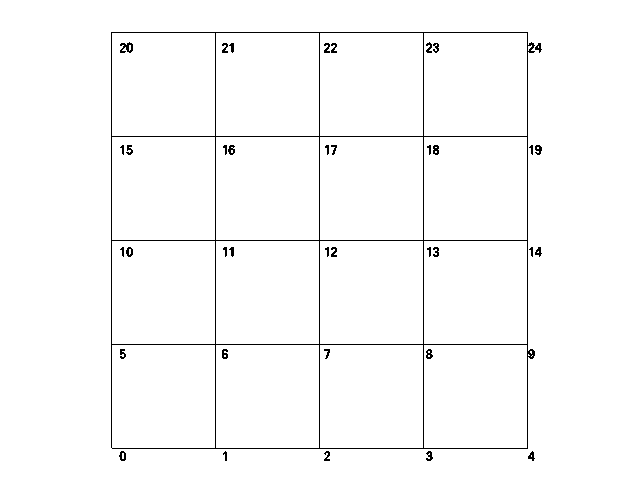

In [3]:
# visualise the mesh
fig = glucifer.Figure()
fig.append(glucifer.objects.Mesh(mesh=mesh, nodeNumbers=True ) )
fig.show()

In [4]:
# explore the mesh's index sets
print mesh.specialSets.keys()

['MaxI_VertexSet', 'MinI_VertexSet', 'AllWalls_VertexSet', 'MinJ_VertexSet', 'MaxJ_VertexSet', 'Empty']


In [5]:
print "The right wall nodes are: ", mesh.specialSets['MaxI_VertexSet']
print "The top wall nodes are  : ", mesh.specialSets["MaxJ_VertexSet"]

The right wall nodes are:  FeMesh_IndexSet([ 4,  9, 14, 19, 24])
The top wall nodes are  :  FeMesh_IndexSet([20, 21, 22, 23, 24])


In [6]:
# initialise the mesh with the boundary conditions
for ii in mesh.specialSets['MinI_VertexSet']:
    tField.data[ii] = 1.0
    
for ii in mesh.specialSets['MaxI_VertexSet']:
    tField.data[ii] = 0.0


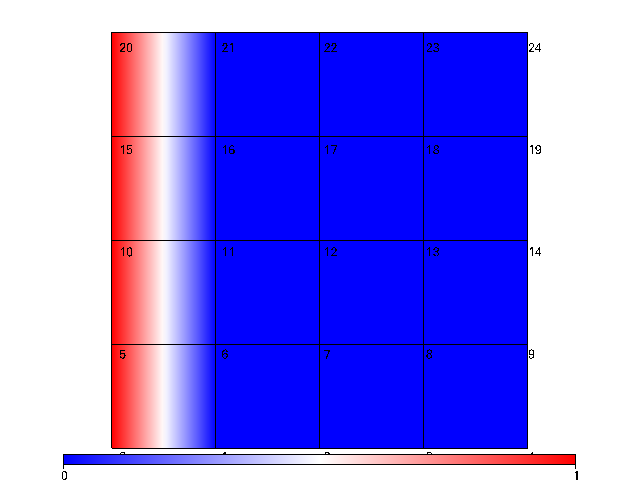

In [7]:
# visualise the new field
fig.append(glucifer.objects.Surface(mesh=mesh, fn=tField, colours=('blue white red')) )
fig.show()

In [8]:
# assign which nodese remain boundary conditions
wallSet = mesh.specialSets['MinI_VertexSet'] + mesh.specialSets['MaxI_VertexSet']
flaggedBCs = uw.conditions.DirichletCondition(tField, indexSetsPerDof=(wallSet,) )

In [9]:
# diffusivity, either defined as a number or as a 'Function object'
type_k = 'constant' # 'constant', linear', 'nonlinear' # CHANGE HERE
if type_k == 'constant':
    diffusivity = uw.function.misc.constant(1.) 
elif type_k == 'linear':
    alpha = uw.function.misc.constant(3.0)
    beta = uw.function.misc.constant(1.0)
    # diffusivity = (alpha*x + beta)^-1
    diffusivity = uw.function.math.pow( alpha * uw.function.coord()[0] + beta, -1.0 )
elif type_k == 'nonlinear':    
    diffusivity = tField + 1.0

In [10]:
# define a systems class with the python objects describing the model 
ss = uw.systems.SteadyStateHeat( temperatureField = tField,
                                 fn_diffusivity = diffusivity,
                                 conditions=[flaggedBCs] )
# ask for the default solver
solver = uw.systems.Solver(ss)

solver.solve() # solve it


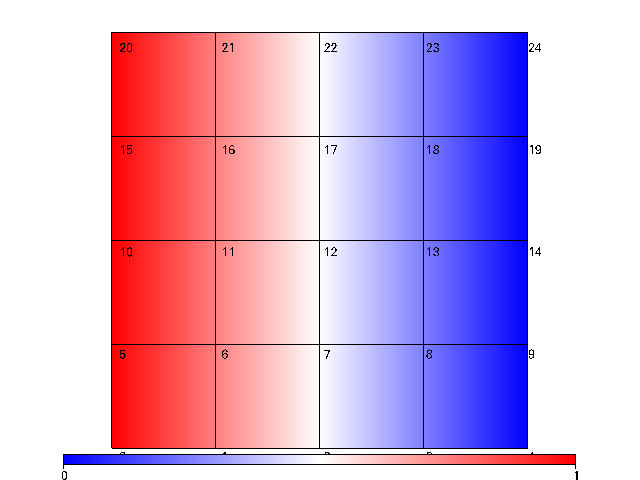

In [11]:
fig.show() # redraw

Analysis time
-------

In [12]:
print "- The value held in memory for node 0:\n",      tField.data[0][0]
print "\n- The nodal values along the bottom wall:\n", tField.evaluate( mesh.specialSets['MinJ_VertexSet'] )
print "\n- The value interpolate at (0.25,0.75):\n",   tField.evaluate( (0.25,0.75) )
print "\n- The diffusivity value at (0.25,0.75):\n",   diffusivity.evaluate( (0.25,0.75) )

- The value held in memory for node 0:
1.0

- The nodal values along the bottom wall:
[[ 1.        ]
 [ 0.74999948]
 [ 0.50000024]
 [ 0.24999938]
 [ 0.        ]]

- The value interpolate at (0.25,0.75):
[[ 0.74999813]]

- The diffusivity value at (0.25,0.75):
[[ 1.]]


In [13]:
# numpy analysis - against exact solution assumed BCs and model domain
import numpy as np

# build some vectors
size      = len(mesh.specialSets['MinJ_VertexSet'].data) # no. vertical nodes
vals      = np.zeros( size )
x_pos     = vals.copy()
exact_sol = vals.copy()

# use IndexSet to evaluate on tField
ids     = mesh.specialSets['MinJ_VertexSet']
vals[:] = tField.evaluate(ids).T          # gets tField values
x_pos   = tField.mesh.data[ids.data,[0]]  # gets the x-coordinates

# evaluate the exact solution to this (1D) probem
if type_k == 'constant':
    exact_sol[:] = 1 - x_pos[:] 
elif type_k == 'linear':
    c0 = -1.0 / ( 0.5*alpha + beta )
    c1 = 1.0
    exact_sol[:] = c0*( 0.5*alpha*x_pos[:]*x_pos[:] + beta*x_pos[:] ) + c1
elif type_k == 'nonlinear':    
    exact_sol[:] = np.sqrt(2) * np.sqrt(2-1.5*x_pos[:]) - 1.0

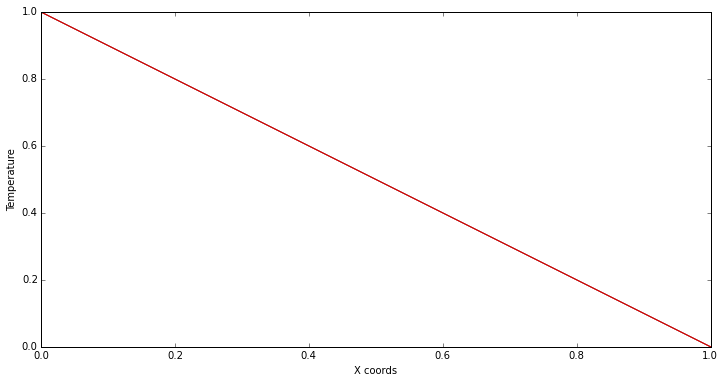

In [14]:
# graph tField profile and exact_solution profile
%matplotlib inline
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
pylab.rcParams[ 'figure.figsize'] = 12, 6
pyplot.plot(x_pos, vals, color = 'black') 
pyplot.plot(x_pos, exact_sol, color = 'red') 
pyplot.xlabel('X coords')
pyplot.ylabel('Temperature')
pyplot.show()

In [15]:
# save the results to disk i.e. checkpoint
mHandle = mesh.save("mesh.h5")
tHandle = tField.save("tField.h5")
tField.xdmf("tField.xdmf", tHandle, "The Temperature Field", mHandle, "The Mesh")